In [1]:
# Import libraries.
using Turing, StatsPlots, Random, Memoization, StatsBase, Statistics, ProgressMeter, SpecialFunctions

## In this notebook we will implement a  Theory Of Mind agents on a version of Poker

### Kuhn Poker

Kuhn poker is an extremely simplified form of poker developed by Harold W. Kuhn as a simple model zero-sum two-player imperfect-information game, amenable to a complete game-theoretic analysis. In Kuhn poker, the deck includes only three playing cards, for example a King, Queen, and Jack. One card is dealt to each player, which may place bets similarly to a standard poker. If both players bet or both players pass, the player with the higher card wins, otherwise, the betting player wins.

#### Rules

In conventional poker terms, a game of Kuhn poker proceeds as follows:

Each player antes 1.
Each player is dealt one of the three cards, and the third is put aside unseen.
Player one can check or bet 1.
* If player one checks then player two can check or bet 1.
    * If player two checks there is a showdown for the pot of 2 (i.e. the higher card wins 1 from the other player).
    * If player two bets then player one can fold or call.
        * If player one folds then player two takes the pot of 3 (i.e. winning 1 from player 1).
        * If player one calls there is a showdown for the pot of 4 (i.e. the higher card wins 2 from the other player).
* If player one bets then player two can fold or call.
    * If player two folds then player one takes the pot of 3 (i.e. winning 1 from player 2).
    * If player two calls there is a showdown for the pot of 4 (i.e. the higher card wins 2 from the other player).

#### Optimal strategy


The game has a mixed-strategy Nash equilibrium; when both players play equilibrium strategies, the first player should expect to lose at a rate of −1/18 per hand (as the game is zero-sum, the second player should expect to win at a rate of +1/18). There is no pure-strategy equilibrium.

Kuhn demonstrated there are infinitely many equilibrium strategies for the first player, forming a continuum governed by a single parameter. In one possible formulation, player one freely chooses the probability $\alpha$ $\in$ [0,1/3] with which he will bet when having a Jack (otherwise he checks; if the other player bets, he should always fold). When having a King, he should bet with the probability of $3\alpha$ (otherwise he checks; if the other player bets, he should always call). He should always check when having a Queen, and if the other player bets after this check, he should call with the probability of $\alpha$ +1/3.

The second player has a single equilibrium strategy: Always betting or calling when having a King; when having a Queen, checking if possible, otherwise calling with the probability of 1/3; when having a Jack, never calling and betting with the probability of 1/3.

#### Pseudo Code Model

* game_simulation(num_of_round):
    * c1 , c2 ~ Deck() <br>

    * player1_history = [] <br>
    * player2_history = [] <br>

    * for i in length(num_of_rounds):
       * m1 = agent(c1, player2_history, deception_alpha) <br>
       * player1_history.append(m1) <br>
       * m2 = agent(c2, player1_history, deception_alpha) <br>
       * player2_history.append(m2) <br>
<br><br><br>
* agent(card , opp_history, decption_alpha):
    * opp_card ~ Deck(deck.pop(card))
    * opp_move ~ opp_model(opp_card, last_action)
    * return select_move(opp_move, card, deception_alpha)

In [2]:
JACK = 1
QUEEN = 2
KING = 3
FULL_DECK = [JACK, QUEEN, KING]

3-element Array{Int64,1}:
 1
 2
 3

In [3]:
FOLD = -1
CHECK = 0
BET = 1
ACTIONS = [FOLD, CHECK, BET]

3-element Array{Int64,1}:
 -1
  0
  1

#### This method is implementation of first player equilibrium strategy

In [4]:
function first_player_select_move(card, deception_alpha, opp_betting)
   if card == JACK
        if opp_betting
            return FOLD    
        elseif rand() < deception_alpha
            return BET # bluff
        else
            return CHECK
        end
    elseif card == KING
        need_to_bet = rand() < 3 * deception_alpha
        if need_to_bet && !opp_betting
            return BET
        else   # slow playing
            return CHECK
        end
    else # queen
        need_to_call = rand() < deception_alpha + 1/3
        if !need_to_call && opp_betting
            return FOLD
        else
            return CHECK
        end
    end
end

first_player_select_move (generic function with 1 method)

#### This method is implementation of second player equilibrium strategy

In [5]:
function second_player_select_move(card, opp_betting)
   if card == JACK
        if opp_betting
            return FOLD    
        elseif rand() < 1/3
            return BET # bluff
        else
            return CHECK
        end
    elseif card == KING
        if  opp_betting
            return CHECK
        else   # slow playing
            return BET
        end
    else # queen
        need_to_call = rand() < 1/3
        if !need_to_call && opp_betting
            return FOLD
        else
            return CHECK
        end
    end
end

second_player_select_move (generic function with 1 method)

In [6]:
function round(first_card, second_card, deception_alpha = 0.2)
    first_player_move = first_player_select_move(first_card, deception_alpha, false)
    second_player_move = second_player_select_move(second_card, first_player_move == BET)
#     println("stage 1 first player: $first_player_move second player: $second_player_move")
    doubled_pot = first_player_move == BET || second_player_move == BET
    if second_player_move == FOLD
        return 1
    end
    if second_player_move == BET
        doubled_pot = true
        first_player_move = first_player_select_move(first_card, deception_alpha , true)
#         println("stage 2  first player: $first_player_move second player: $second_player_move")
        if first_player_move == FOLD
            return -1
        end
    end
    if first_card > second_card
        return 1 * (1 + doubled_pot)
    else
        return -1 * (1 + doubled_pot)
    end
end

round (generic function with 2 methods)

In [7]:
round(JACK, KING)

-1

In [8]:
function game(num_of_rounds = 10, deception_alpha=0.2)
    total_score = 0
    for i in 1:num_of_rounds
        first_card, second_card = sample(FULL_DECK, 2; replace=false)
        score = round(first_card, second_card, deception_alpha)
#         println("round $i: first player got $first_card second player got $second_card score is $score")
        total_score += score
    end
    avg_score = total_score / num_of_rounds
    return avg_score
end

game (generic function with 3 methods)

#### we can see that the game is converging to -1/18 as the theory states

In [9]:
game(1000000, 0.25)

-0.054891

In [10]:
game(1000000, 0.1)

-0.055886

In [11]:
game(1000000, 0.01)

-0.056256

### The PPL Approach

### This is modeling of the Nash-EQ agent with PPL ($\alpha$ seed)

In [12]:
@model function agent(card, opp_betting = false, alpha = 0.33333)
    deception_alpha ~ Dirac(alpha)
    if !opp_betting
        if card == JACK
            bet_chance ~ Bernoulli(deception_alpha) # bluff
            return ACTIONS[bet_chance+1]
        elseif card == KING
            check_chance ~ Bernoulli(3 * deception_alpha) # agrassive vs slow playing
            return ACTIONS[2+check_chance]
        else # queen
            return CHECK
        end
    else
        if card == JACK
            return FOLD
        elseif card == KING  
            return CHECK
        else  
            call_chance ~ Bernoulli(deception_alpha + 1/3) # bluff detection
            return ACTIONS[1+call_chance] 
        end
    end
end

agent (generic function with 3 methods)

#### Some simple games with the model

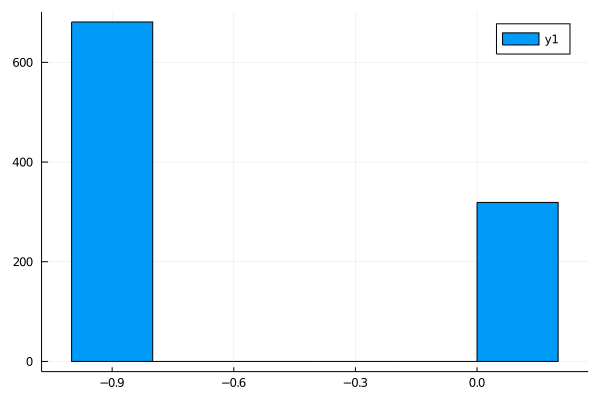

In [13]:
m = agent(JACK)
chains = sample(m, IS(), 1000 , n_chains=1)
histogram(generated_quantities(m, chains))

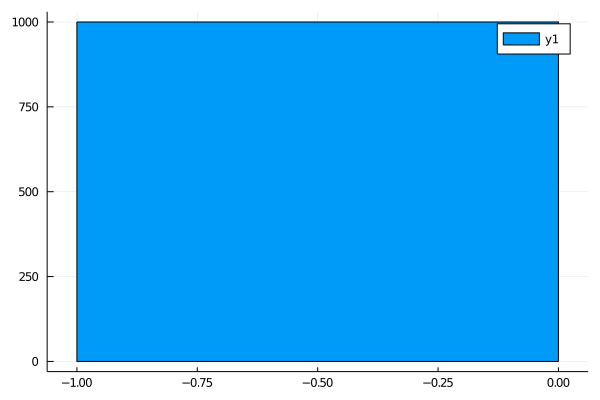

In [14]:
m  = agent(JACK, true)
chains = sample(m, IS(), 1000 , n_chains=1)
histogram(generated_quantities(m, chains))

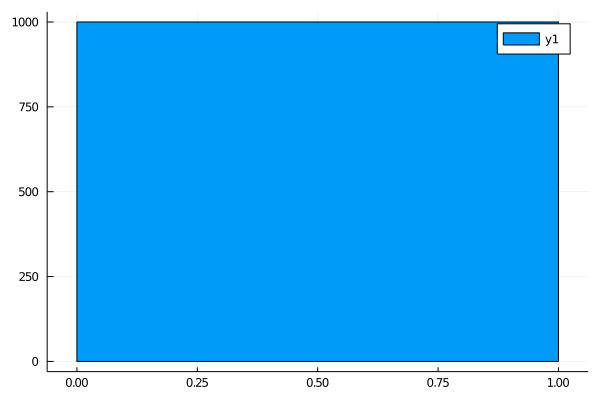

In [15]:
m = agent(QUEEN)
chains = sample(m, IS(), 1000 , n_chains=1, progress = true)
histogram(generated_quantities(m, chains))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


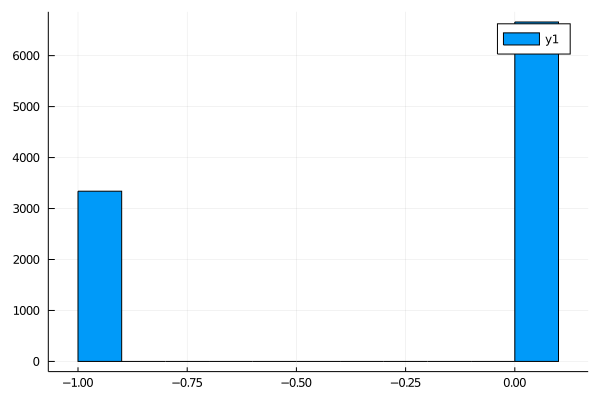

In [16]:
m = agent(QUEEN, true)
chains = sample(m, IS(), 10000 , n_chains=1, progress = true)
histogram(generated_quantities(m, chains))

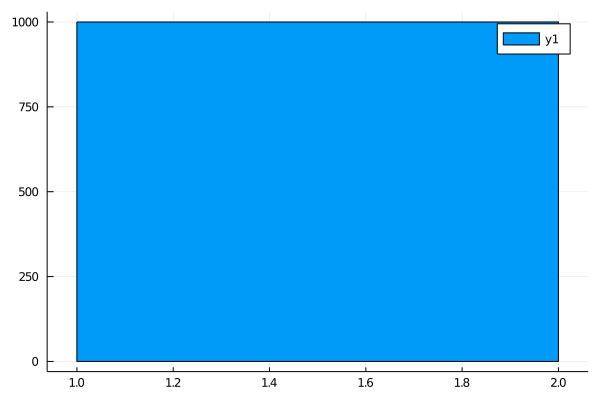

In [17]:
m = agent(KING)
chains = sample(m, IS(), 1000 , n_chains=1, progress = true)
histogram(generated_quantities(m, chains))

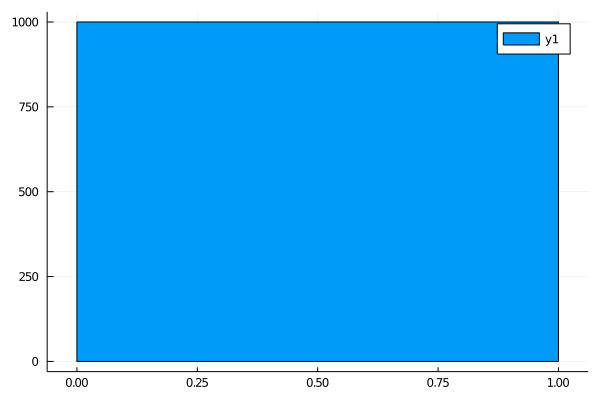

In [18]:
m = agent(KING, true)
chains = sample(m, IS(), 1000 , n_chains=1, progress = true)
histogram(generated_quantities(m, chains))

We want to learn 6 parameters, we will do it by conditioning on the history.
After learning the parameters we will sample a decision as posterior from the learned parameters.

In [19]:
function first_bet_and_won(history)
    first_won = [history[i][2] > 0 for i=1:length(history)]
    first_bet = [history[i][1][1][1][2] == BET for i=1:length(history)]
    return first_bet .& first_won
end

first_bet_and_won (generic function with 1 method)

In [45]:
function second_bet_and_won(history)
    second_won = [history[i][2] < 0 for i=1:length(history)]
    second_bet = [history[i][1][1][2][2] == BET for i=1:length(history)]
    return second_bet .& second_won
end

second_bet_and_won (generic function with 1 method)

In [21]:
function first_call_and_won(history)
    first_won = [history[i][2] > 0 for i=1:length(history)]
    first_call = [length(history[i][1]) > 1 ? history[i][1][2][1][2] == CHECK : false for i=1:length(history)]
    bet_is_on = [length(history[i][1]) > 1 ? history[i][1][2][1][3] : false for i=1:length(history)]
    return first_call .& first_won .& bet_is_on
end

first_call_and_won (generic function with 1 method)

In [22]:
function second_call_and_won(history)
    second_won = [history[i][2] < 0 for i=1:length(history)]
    second_call = [history[i][1][1][2][2] == CHECK for i=1:length(history)]
    bet_is_on = [history[i][1][1][2][3] for i=1:length(history)]
    return second_call .& second_won .& bet_is_on
end

second_call_and_won (generic function with 1 method)

In [46]:
@model function poker_agent(my_card, bet_is_on = false, history=[], called_and_won=[], betted_and_won = [], player_index = 1)
    j_call ~ Uniform(0, 1)
    j_bet ~ Uniform(0, 1)
    q_call ~ Uniform(0, 1)
    q_bet ~ Uniform(0, 1)
    k_call ~ Uniform(0, 1)
    k_bet ~ Uniform(0, 1)
    
    # learning phase
    for i in 1:length(history)
        stages = history[i][1]
#         println("stages $stages")
        for j in 1:length(stages)
#             println("history[i][1][j] $history[i][1][j]")
            i_is_betting_round = history[i][1][j][player_index][3]
            
            # extracting player's information
            i_my_card = history[i][1][j][player_index][1]
            i_my_action = history[i][1][j][player_index][2]

            if i_is_betting_round
                if i_my_card == JACK
                    called_and_won[i] ~ Bernoulli(j_call)
                    # negative reward to call
                elseif i_my_card == QUEEN
                    called_and_won[i] ~ Bernoulli(q_call)
                    # when the other play has jack - positive
                    # else negative
                else # King
                    called_and_won[i] ~ Bernoulli(k_call)
                    # positive reward to call
                end
            else
                if i_my_card == JACK
                    betted_and_won[i] ~ Bernoulli(j_bet)
                    # when the other player folded - positive
                    # when called - negative
                elseif i_my_card == QUEEN
                    betted_and_won[i] ~ Bernoulli(q_bet)
                    # when other player has Jack positive, otherwise negative 
                else # King
                    betted_and_won[i] ~ Bernoulli(k_bet)
                    # positive reward to call, more positive towards slowplaying and then other calling
                end
            end
        end
    end
    
    # decision phase
    if bet_is_on
        if my_card == JACK
            action ~ Bernoulli(j_call)
        elseif my_card == QUEEN
            action ~ Bernoulli(q_call)
        else # King
            action ~ Bernoulli(k_call)
        end
    else
        if my_card == JACK
            action ~ Bernoulli(j_bet)
        elseif my_card == QUEEN            
            action ~ Bernoulli(q_bet)
            # when other player has Jack positive, otherwise negative 
        else # King
            action ~ Bernoulli(k_bet)
        end
    end
    return action
end

poker_agent (generic function with 6 methods)

### given chain result (posterior), sample an action

In [24]:
# Plot the results
function plotChn_action(chn)
    histogram(chn[:action], weights=exp.(chn[:lp]), normalize=:probability)
end

plotChn_action (generic function with 1 method)

In [25]:
function sample_action_from_computed_posterior(chn)
    weights = exp.(chn[:lp][:, 1])
    weights = Weights(weights/sum(weights))
    idx = sample(collect(1:length(weights)), weights)
    move_sample = chn[:action][idx, 1]
    return move_sample
end

sample_action_from_computed_posterior (generic function with 1 method)

### Posterior of actions without history

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


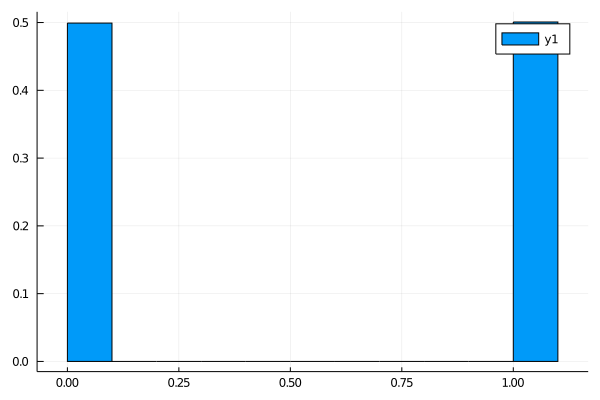

In [36]:
m = poker_agent(JACK)
chn = sample(m, IS() , 10000 , n_chains=1)
plotChn_action(chn)

### Conditioning on history

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


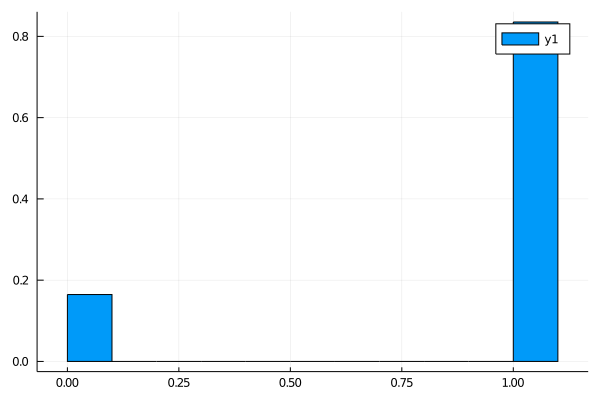

In [47]:
history = [([((JACK, BET, false), (KING, FOLD , true))], 1), ([((JACK, BET, false), (KING, FOLD , true))], 1), ([((JACK, BET, false), (KING, FOLD , true))], 1), ([((JACK, BET, false), (KING, FOLD , true))], 1)]
m = poker_agent(JACK, false, history, first_call_and_won(history), first_bet_and_won(history), 1)
chn = sample(m, IS() , 10000 , n_chains=1)
plotChn_action(chn)

In [29]:
function sample_action_from_model(m)
    chn = sample(m, IS() , 10000 , n_chains=1, progress = false)
    return sample_action_from_computed_posterior(chn)
end

sample_action_from_model (generic function with 1 method)

In [39]:
function round(first_card, second_card, first_agent, second_agent, history)
    score = 0
    
    m1 = first_agent(first_card, false, history, first_call_and_won(history), first_bet_and_won(history), 1)
    first_player_move = sample_action_from_model(m1)
    
    m2 = second_agent(second_card, first_player_move == BET, history, second_call_and_won(history), second_bet_and_won(history), 2)
    second_player_move = sample_action_from_model(m2)
    round_history = [((first_card, first_player_move, first_player_move == BET), (second_card, second_player_move, second_player_move == BET))]
    
    doubled_pot = first_player_move == BET || second_player_move == BET
    if second_player_move == FOLD
        return 1
    end
    if second_player_move == BET
        doubled_pot = true
        m1 = first_agent(first_card, true, history, first_call_and_won(history), first_bet_and_won(history), 1)
        first_player_move = sample_action_from_model(m1)
        push!(round_history, ((first_card, first_player_move, false),(-10, -10, false)))
        if first_player_move == FOLD
            return -1
        end
    end
    if first_card > second_card
        score =  1 * (1 + doubled_pot)
    else
        score = -1 * (1 + doubled_pot)
    end
    round_record = (round_history, score)
    push!(history, round_record)
    return score
end

round (generic function with 3 methods)

In [40]:
function game(num_of_rounds = 10)
    total_score = 0
    history = []
    for i in 1:num_of_rounds
        first_card, second_card = sample(FULL_DECK, 2; replace=false)
        score = round(first_card, second_card, poker_agent, poker_agent, history)
        total_score += score
    end
    print(history)
    avg_score = total_score / num_of_rounds
    return avg_score
end

game (generic function with 3 methods)

In [48]:
game()

round record is (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((3, 1.0, 1), (2, 1.0, 1)), ((3, 0.0, 0), (-10, -10.0, 0))], 2)
history in round 1 is Any[(Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((3, 1.0, 1), (2, 1.0, 1)), ((3, 0.0, 0), (-10, -10.0, 0))], 2)]
round record is (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((1, 0.0, 0), (3, 1.0, 1)), ((1, 1.0, 0), (-10, -10.0, 0))], -2)
history in round 2 is Any[(Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((3, 1.0, 1), (2, 1.0, 1)), ((3, 0.0, 0), (-10, -10.0, 0))], 2), (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((1, 0.0, 0), (3, 1.0, 1)), ((1, 1.0, 0), (-10, -10.0, 0))], -2)]
round record is (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((2, 0.0, 0), (1, 1.0, 1)), ((2, 0.0, 0), (-10, -10.0, 0))], 2)
history in round 3 is Any[(Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((3, 1.0, 1), (2, 1.0, 1)), ((3, 0.0, 0), (-10, -10.0, 0))], 2), 

0.1

In [49]:
game(100)

round record is (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((1, 0.0, 0), (2, 0.0, 0))], -1)
history in round 1 is Any[(Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((1, 0.0, 0), (2, 0.0, 0))], -1)]
round record is (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((2, 0.0, 0), (1, 1.0, 1)), ((2, 1.0, 0), (-10, -10.0, 0))], 2)
history in round 2 is Any[(Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((1, 0.0, 0), (2, 0.0, 0))], -1), (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((2, 0.0, 0), (1, 1.0, 1)), ((2, 1.0, 0), (-10, -10.0, 0))], 2)]
round record is (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((1, 0.0, 0), (2, 0.0, 0))], -1)
history in round 3 is Any[(Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((1, 0.0, 0), (2, 0.0, 0))], -1), (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((2, 0.0, 0), (1, 1.0, 1)), ((2, 1.0, 0), (-10, -10.0, 0))], 2), (Tuple{Tuple{Int64,Float64,Bool}

0.16

In [ ]:
game(1000)

round record is (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((2, 1.0, 1), (3, 1.0, 1)), ((2, 1.0, 0), (-10, -10.0, 0))], -2)
history in round 1 is Any[(Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((2, 1.0, 1), (3, 1.0, 1)), ((2, 1.0, 0), (-10, -10.0, 0))], -2)]
round record is (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((3, 1.0, 1), (1, 0.0, 0))], 2)
history in round 2 is Any[(Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((2, 1.0, 1), (3, 1.0, 1)), ((2, 1.0, 0), (-10, -10.0, 0))], -2), (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((3, 1.0, 1), (1, 0.0, 0))], 2)]
round record is (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((2, 0.0, 0), (1, 0.0, 0))], 1)
history in round 3 is Any[(Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((2, 1.0, 1), (3, 1.0, 1)), ((2, 1.0, 0), (-10, -10.0, 0))], -2), (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((3, 1.0, 1), (1, 0.0, 0))], 2), (

Excessive output truncated after 524558 bytes.

round record is (Tuple{Tuple{Int64,Float64,Bool},Tuple{Int64,Float64,Bool}}[((2, 0.0, 0), (1, 1.0, 1)), ((2, 0.0, 0), (-10, -10.0, 0))], 2)
